In [1]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings
from metpy.interpolate import cross_section
from cartopy import geodesic
import shapely

warnings.simplefilter("ignore")

def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-") 

def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143; max_lon=146; min_lat=-39.5; max_lat=-36.5
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149; max_lon=152; min_lat=-35; max_lat=-32
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151; max_lon=154; min_lat=-29; max_lat=-26
    elif rid=="66":
        min_lon=150; max_lon=155; min_lat=-29; max_lat=-25
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="x", mew=2, ms=12, color="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (DBZ)")
    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60*6), time]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    radar_file = pyart.io.read_grid(target_files[0])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file 

def load_radar_range(rid, times):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    out = []
    time_out = []
    for f in tqdm.tqdm(target_files):
            radar_file = pyart.io.read_grid(f).to_xarray().corrected_reflectivity.isel({"time":0}).max("z")
            out.append(radar_file.values)
            time_out.append(radar_file.time.values)
    
    _ = [os.remove(f) for f in target_files]
    
    return out, time_out, radar_file.lon.values, radar_file.lat.values

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#Load the WRF simulation output. Currently, the standard wrfout files are hourly, whereas the highres files are 10-minute, but only contain surface winds
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/wrfout*d03*"))]
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/wrfout*d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/wrfout*d01*"))]
wrflist_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/highres*d03*"))]
wrflist_d02_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/highres*d02*"))]
wrflist_d03_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/nsw_d03_20170408_20170410/highres*d01*"))]

In [3]:
#From the highres wind data, get the wind speed
#U10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
#V10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
U10E = wrf.getvar(wrflist_hr, "U10E", timeidx=wrf.ALL_TIMES)
V10E = wrf.getvar(wrflist_hr, "V10E", timeidx=wrf.ALL_TIMES)
speed = np.sqrt(U10E**2+V10E**2)
times = wrf.extract_times(wrflist_hr,wrf.ALL_TIMES)

In [4]:
#Load AWS data for this event (loading the whole year is most convenient, but takes a while)
aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nsw_one_min_gust/2017.csv")
aws = aws.set_index(pd.DatetimeIndex(aws.dt_utc))

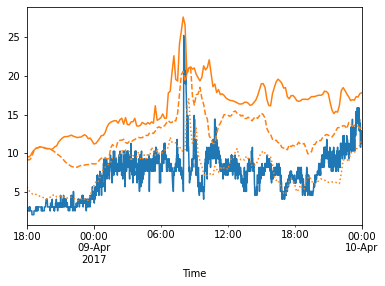

In [5]:
#Compare the sydney airport AWS gust time series with the closest WRF point


ax=plt.axes()
aws[aws.stn_id==66037].loc[slice("2017-04-08 18:00","2017-04-10 00:00")].gust.plot(ax=ax)



compare="neighbourhood"

if compare=="point":

    lat, lon = (-33.9465, 151.1731)
    x,y=wrf.ll_to_xy(wrflist_hr, lat, lon).values
    speed.sel({"south_north":y, "west_east":x}).to_dataframe(name="speed").speed.plot(ax=ax,color="tab:orange")
    
elif compare=="domain_max":

    pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).plot(color="tab:orange",ax=ax)
    
elif compare=="neighbourhood":

    lat, lon = (-33.9465, 151.1731)    
    
    r=100
    dist = latlon_dist(lat, lon, 
                wrf.getvar(wrflist_hr, "XLAT", timeidx=0).values, 
                wrf.getvar(wrflist_hr, "XLONG", timeidx=0).values)
    xr.where(dist<=r, speed, np.nan).max(("south_north","west_east")).to_dataframe(name="speed").speed.plot(ax=ax,color="tab:orange")
    
    r=50
    dist = latlon_dist(lat, lon, 
                wrf.getvar(wrflist_hr, "XLAT", timeidx=0).values, 
                wrf.getvar(wrflist_hr, "XLONG", timeidx=0).values)
    xr.where(dist<=r, speed, np.nan).max(("south_north","west_east")).to_dataframe(name="speed").speed.plot(ax=ax,color="tab:orange",ls="--")    
    
    r=10
    dist = latlon_dist(lat, lon, 
                wrf.getvar(wrflist_hr, "XLAT", timeidx=0).values, 
                wrf.getvar(wrflist_hr, "XLONG", timeidx=0).values)
    xr.where(dist<=r, speed, np.nan).max(("south_north","west_east")).to_dataframe(name="speed").speed.plot(ax=ax,color="tab:orange",ls=":")        

In [6]:
#Get the observed radar data from t0 for a number of hours, taking the column max

hourly_times = []
t0=dt.datetime(2017,4,9,6)
hours=8
for t in np.arange(hours):
    t_temp = t0 + dt.timedelta(hours=float(t))
    print(t_temp)
    hourly_times.append(t_temp)

a, b, lon, lat =load_radar_range("71",[t0+ dt.timedelta(hours=-1),hourly_times[-1]])

a=np.stack(a)
b=np.stack(b)

hourly_radar = []
for t_temp in hourly_times:
    hourly_radar.append(np.nanmax(a[(b> (t_temp+dt.timedelta(hours=-1))) & (b<t_temp)],axis=0))

2017-04-09 06:00:00
2017-04-09 07:00:00
2017-04-09 08:00:00
2017-04-09 09:00:00
2017-04-09 10:00:00
2017-04-09 11:00:00
2017-04-09 12:00:00
2017-04-09 13:00:00


100%|██████████| 80/80 [00:13<00:00,  5.92it/s]


In [7]:
def plot(file_list,v,t_ind,ax,levels=None,cmap=None,lev=None):
    
    #Code to plot la-lon contours of various quantities
    
    if v == "REFL_10CM":
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}).max("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    elif v == "THETA":
        p1 = wrf.getvar(file_list, "theta", timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)      
    elif v == "THETA-E":
        p1 = wrf.getvar(file_list, "theta_e", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)              
    elif v == "W_MIN":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        p1 = xr.where(heights < 3000, p1, np.nan)
        c=xr.plot.contourf(p1.min("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    elif v == "W":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values
        p1 = wrf.interplevel(p1,heights,lev)
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)                
    elif v == "WS10":
        p1 = wrf.getvar(file_list, "U10E", timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        p2 = wrf.getvar(file_list, "V10E", timeidx=wrf.ALL_TIMES, method="cat")
        p=np.sqrt(p1**2+p2**2)
        p.attrs=p1.attrs
        c=xr.plot.contourf(p.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    else:
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    plt.title(time)
        

In [8]:
hourly_speed = speed.resample({"Time":"1H"},label="right",closed="left").max()


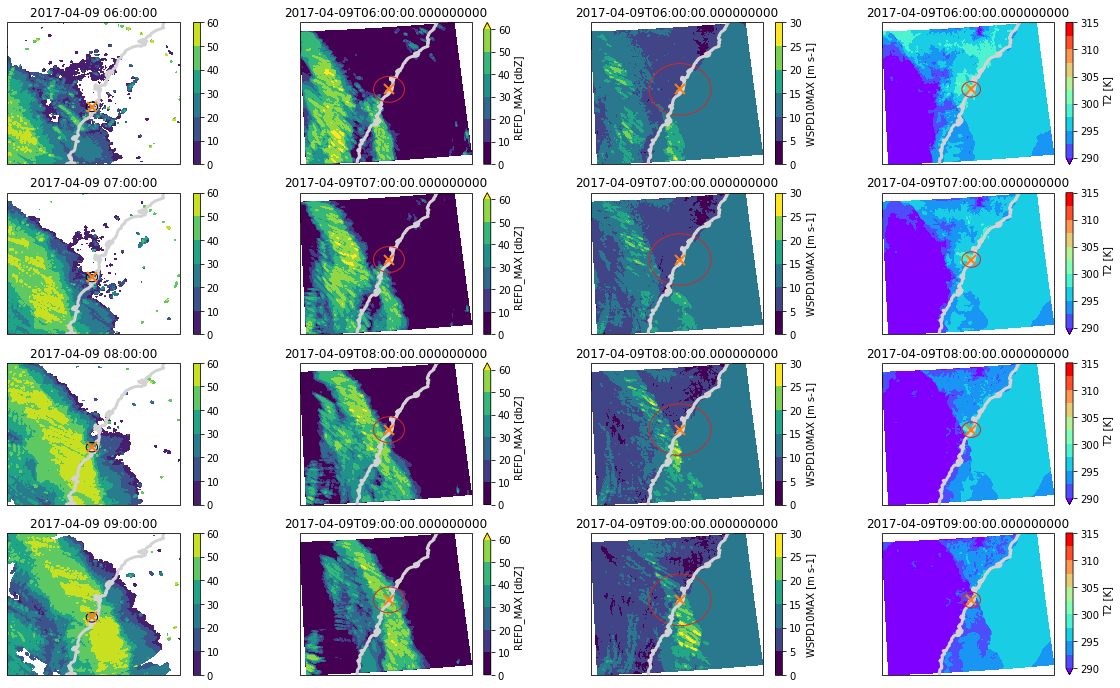

In [9]:
#Compare the radar and model reflectivity for each hour of model output, starting at the index t0.
#Aldo show Wind speed and surface temperature

plt.figure(figsize=[20,12])

rows=4;cols=4
t0=12

cnt=0
x,y = np.meshgrid(lon,lat)
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    c=ax.contourf(x,y,hourly_radar[cnt],levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    ax.set_title(hourly_times[cnt])
    plt.colorbar(c)
    plat, plon = (-33.9465, 151.1731)
    ax.plot(plon,plat,marker="x",ms=10,mew=2,color="tab:orange")
    plot_range_rings(plon,plat,10,ax)
    cnt=cnt+1
    
cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    plot(wrflist,"REFD_MAX",t0+cnt,ax,levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    plat, plon = (-33.9465, 151.1731)
    ax.plot(plon,plat,marker="x",ms=10,mew=2,color="tab:orange")
    plot_range_rings(plon,plat,50,ax,color="tab:red")
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    plot(wrflist,"WSPD10MAX",t0+cnt,ax,levels=np.arange(0,35,5))
 #   xr.plot.contourf(hourly_speed.isel({"Time":t0+cnt-1}),
#                                   x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=None,cmap=None)
    plat, plon = (-33.9465, 151.1731)
    ax.plot(plon,plat,marker="x",ms=10,mew=2,color="tab:orange")
    plot_range_rings(plon,plat,100,ax,color="tab:red")
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    plot(wrflist,"T2",t0+cnt,ax,levels=np.arange(290,317.25,2.5),cmap=plt.get_cmap("rainbow"))
    plat, plon = (-33.9465, 151.1731)
    ax.plot(plon,plat,marker="x",ms=10,mew=2,color="tab:orange")
    ax.coastlines(color="lightgray",lw=3)
    plot_range_rings(plon,plat,30,ax,color="tab:red")
    cnt=cnt+1
    
#plt.savefig("/g/data/eg3/ab4502/figs/wrf_20200131.png",box_inches="tight")

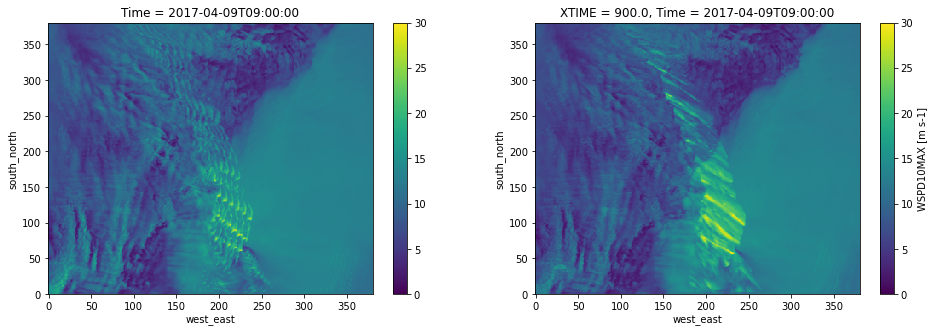

In [10]:
plt.figure(figsize=[16,5])

plt.subplot(1,2,1)
hourly_speed.isel({"Time":14}).plot(vmin=0,vmax=30)

plt.subplot(1,2,2)
wrf.getvar(wrflist,"WSPD10MAX",timeidx=15).plot(vmin=0,vmax=30)

In [11]:
plon, plat

(151.1731, -33.9465)

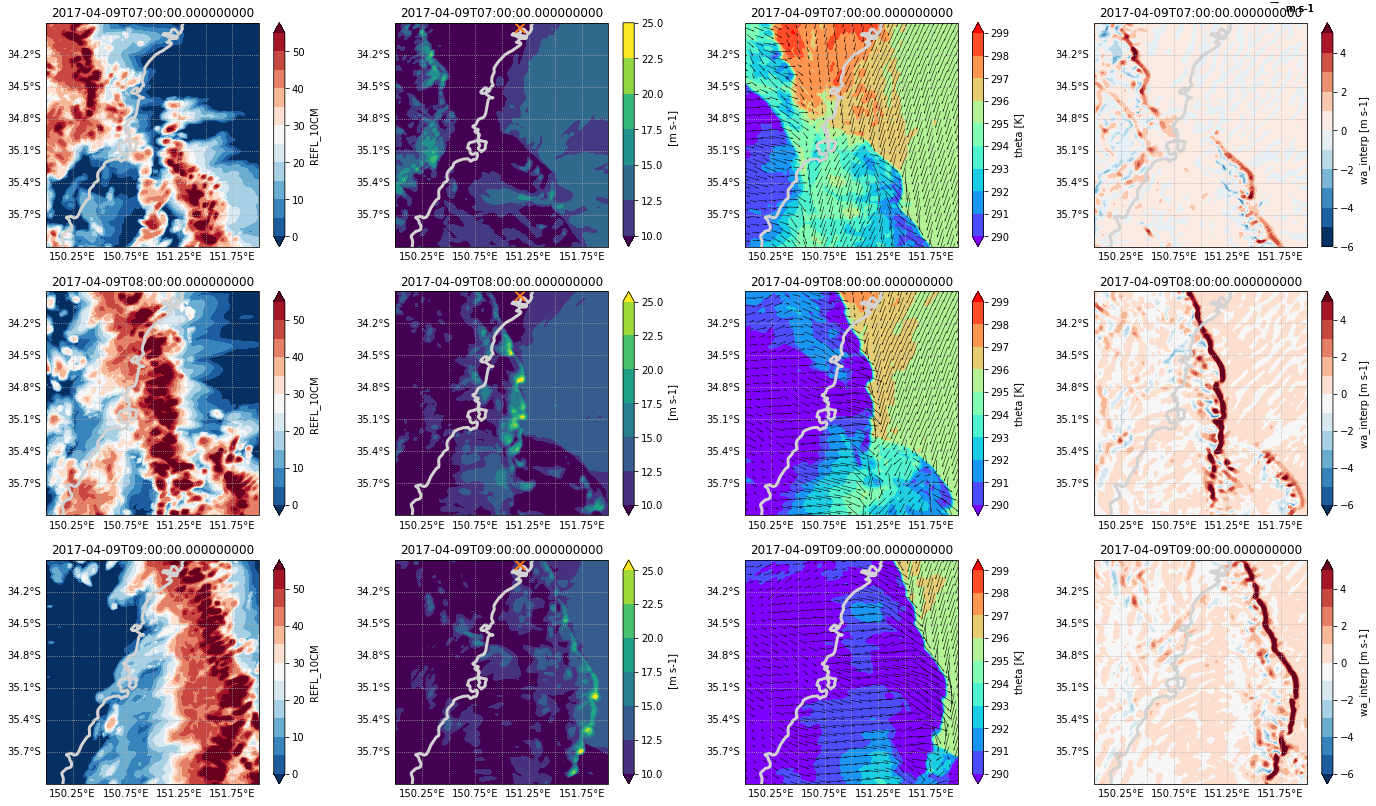

In [12]:
#Now, just for WRF, zoom in on a region, and plot the same fields (plus vertical velocity and theta)

plt.figure(figsize=[24,14])

rows=3;cols=4
t0=13

xlim = [150, 152]
ylim = [-36, -33.9]

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"W",t0+cnt,ax,levels=np.arange(-6,6,1),lev=1500)#cmap=plt.get_cmap("Blues_r"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"REFL_10CM",t0+cnt,ax,levels=np.arange(0,60,5))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"WS10",t0+cnt,ax,levels=np.arange(10,27.5,2.5))
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    ax.coastlines(color="lightgray",lw=3)
    ax.plot(plon,plat,marker="x",ms=10,mew=2,color="tab:orange")    
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"THETA",t0+cnt,ax,levels=np.arange(290,300,1),cmap=plt.get_cmap("rainbow"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    
    u=wrf.getvar(wrflist,"U10",timeidx=t0+cnt)
    v=wrf.getvar(wrflist,"V10",timeidx=t0+cnt)
    xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":6,"west_east":6},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)   
    plt.title(u.Time.values)
    cnt=cnt+1
    
#plt.savefig("/g/data/eg3/ab4502/figs/wrf_20200131_zoomed.png",box_inches="tight")

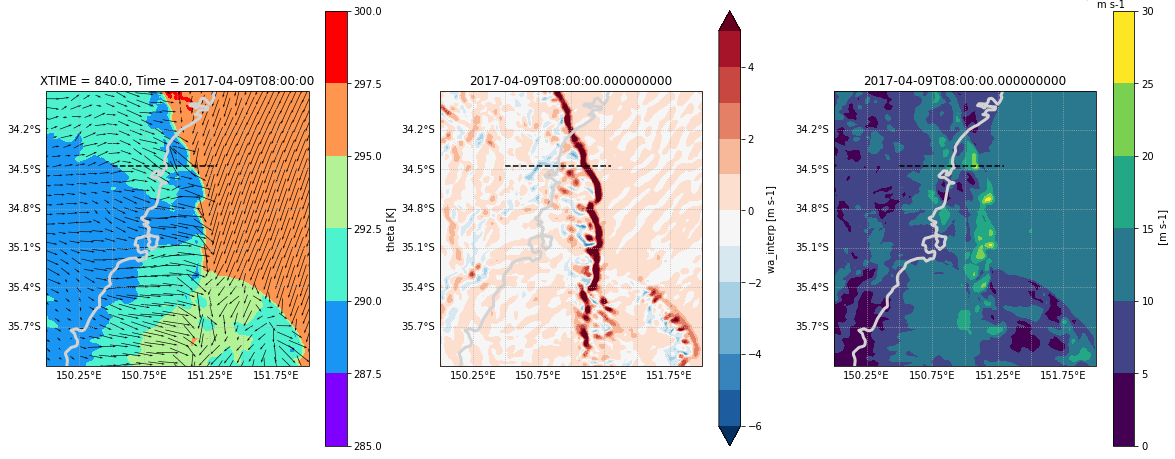

In [13]:
#Take a transect through one of these cell. Display the transects on theta/vertical velocity fields.
#Then, plot transect-height view of cloud water/rain/ice 

t_ind=14

xlim = [150, 152]
ylim = [-36, -33.9]
lats = [-34.475,-34.475]
lons = [150.5,151.3]

#PLOT THETA WITH TRANSECT
plt.figure(figsize=[20,8])
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"THETA",t_ind,ax,cmap=plt.get_cmap("rainbow"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.getvar(wrflist,"U10",timeidx=t_ind)
v=wrf.getvar(wrflist,"V10",timeidx=t_ind)
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":6,"west_east":6},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons, lats,color="k",ls="--")

#PLOT W WITH TRANSECT
ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W",t_ind,ax,lev=1500,levels=np.arange(-6,6,1))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons, lats,color="k",ls="--")

#PLOT W WITH TRANSECT
ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"WS10",t_ind,ax)
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons, lats,color="k",ls="--")

(0.0, 15000.0)

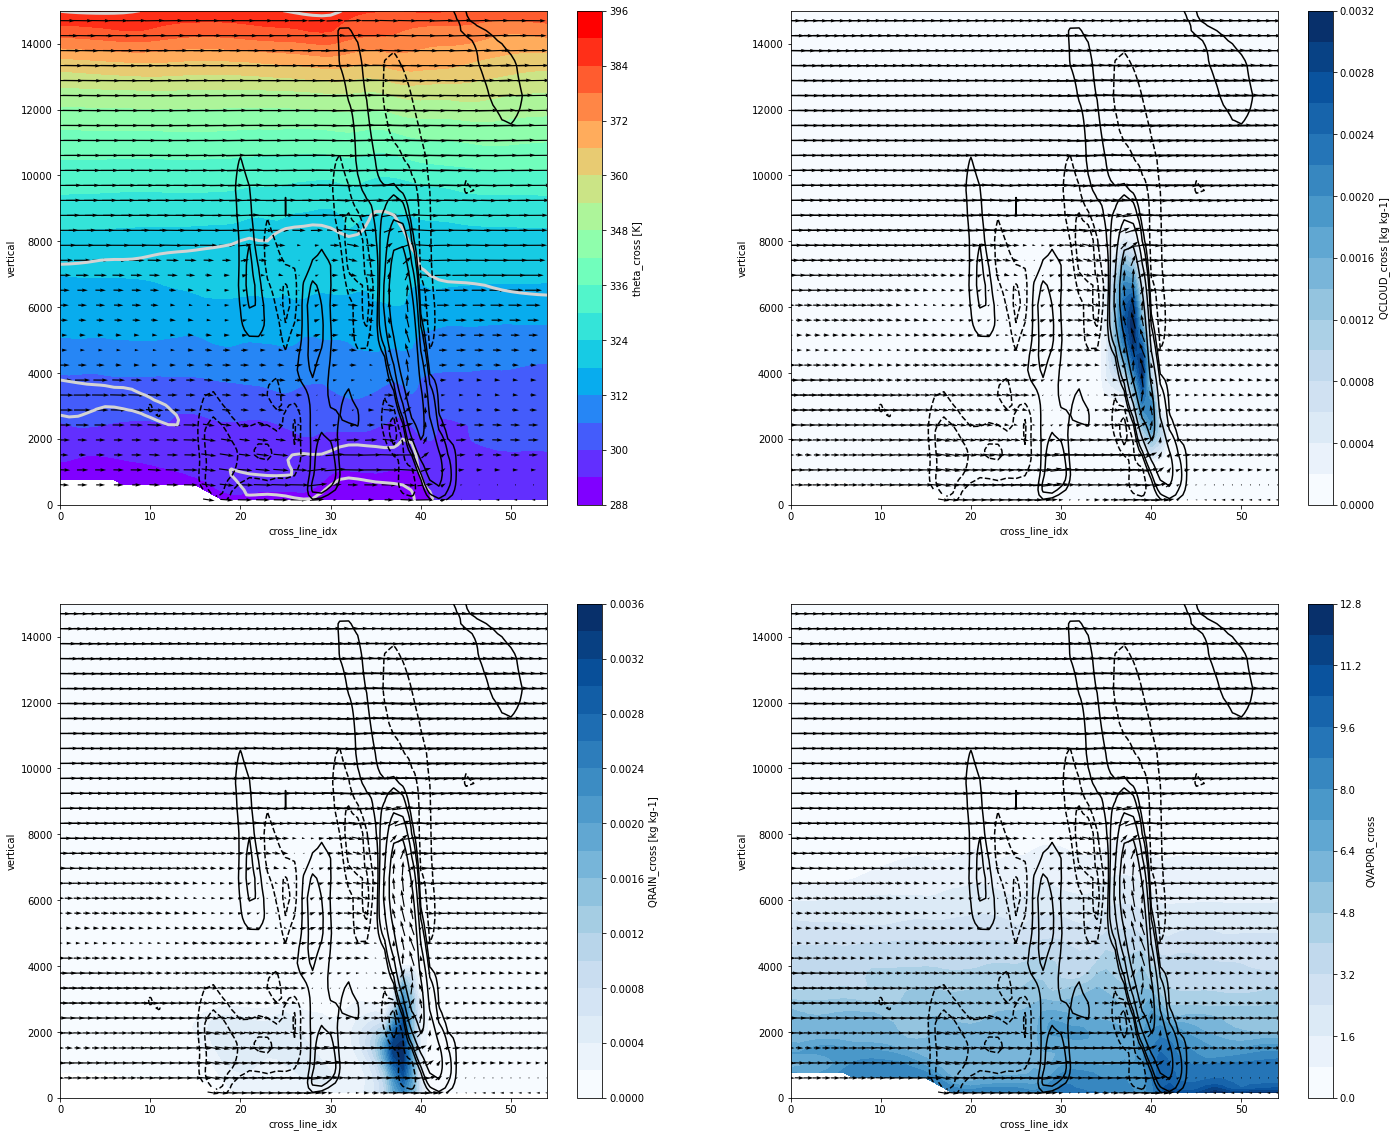

In [14]:
#Calculate transect-height view and plot
theta = wrf.getvar(wrflist,"theta",timeidx=t_ind)
heights = wrf.getvar(wrflist,"z",timeidx=t_ind)
U = wrf.getvar(wrflist,"U",timeidx=t_ind)
V = wrf.getvar(wrflist,"V",timeidx=t_ind)
QR = wrf.getvar(wrflist,"QRAIN",timeidx=t_ind)
QC = wrf.getvar(wrflist,"QCLOUD",timeidx=t_ind)
QV = wrf.getvar(wrflist,"QVAPOR",timeidx=t_ind)
W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)
P = wrf.getvar(wrflist, "P",timeidx=t_ind)
PB = wrf.getvar(wrflist, "PB",timeidx=t_ind)

start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=15000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
pb_cross = wrf.vertcross(PB,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

plt.figure(figsize=[24,20])

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(vv_cross,levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

(0.0, 15000.0)

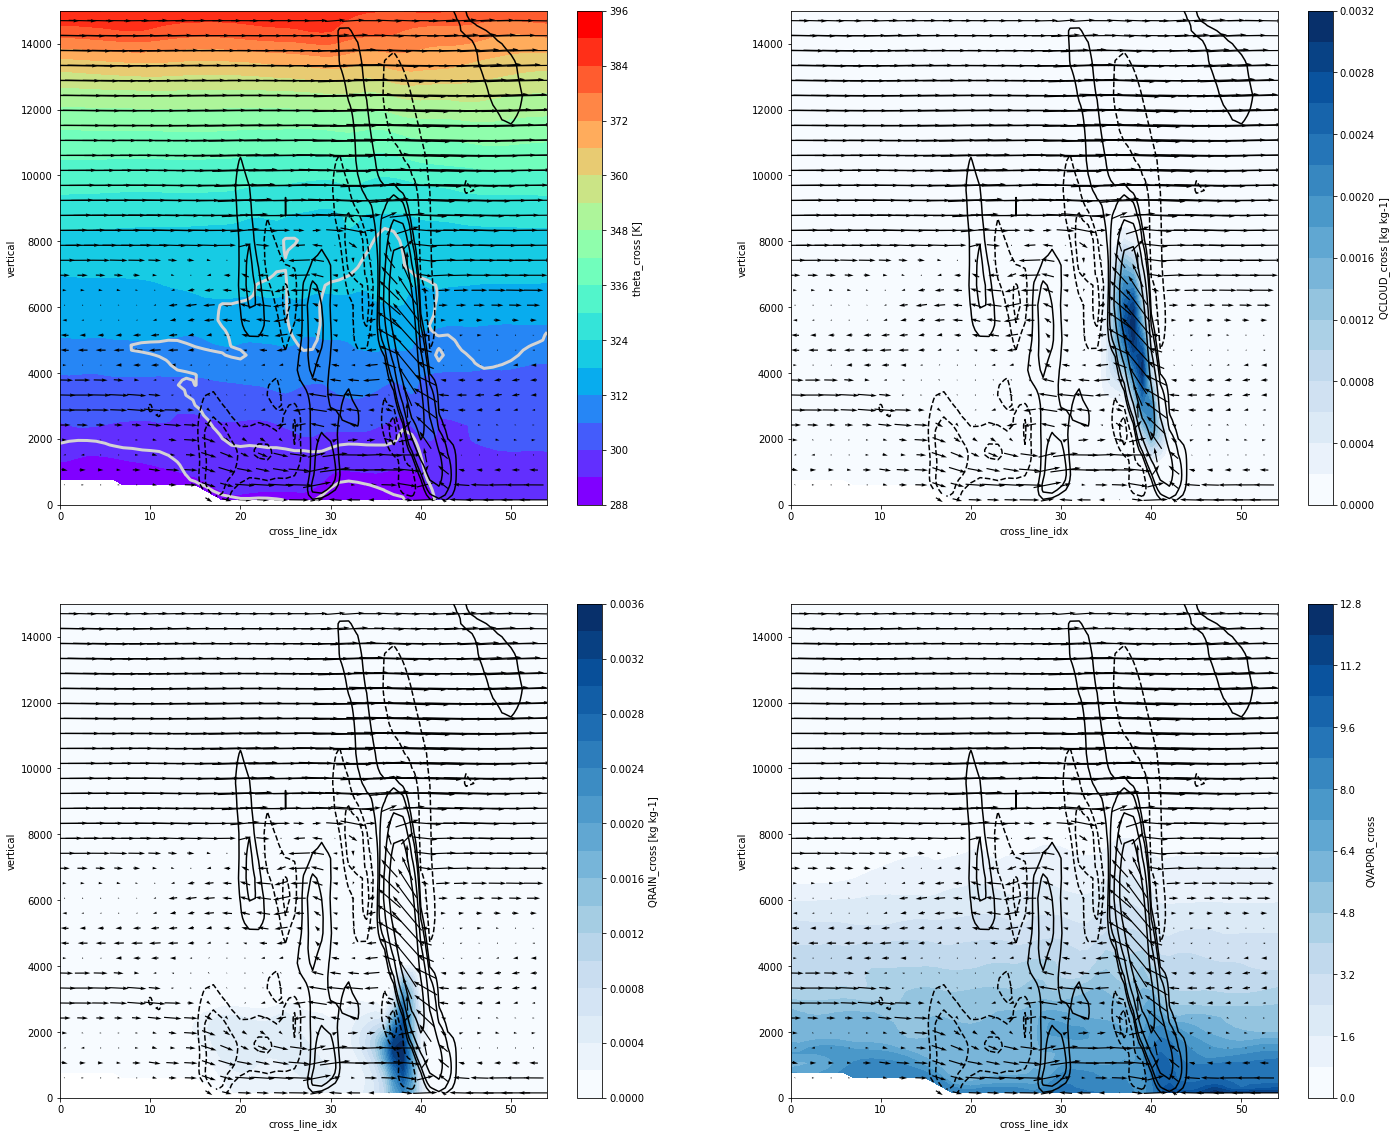

In [15]:
#Plot the same transects, but with storm-relative (using the 0-6 km mean) winds

plt.figure(figsize=[24,20])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-10,-5,-2,-1,1,2,5,10],colors="k")
plt.ylim([0,15000])

(0.0, 12000.0)

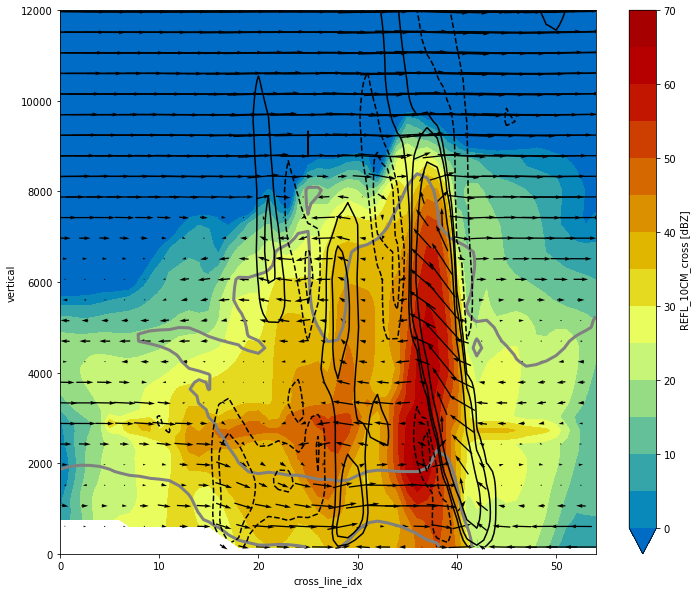

In [17]:
#Same plot but with model reflectivity

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(np.sqrt(((u_cross**2) + (v_cross**2))),levels=[20],colors="gray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")
plt.ylim([0,12000])

(0.0, 12000.0)

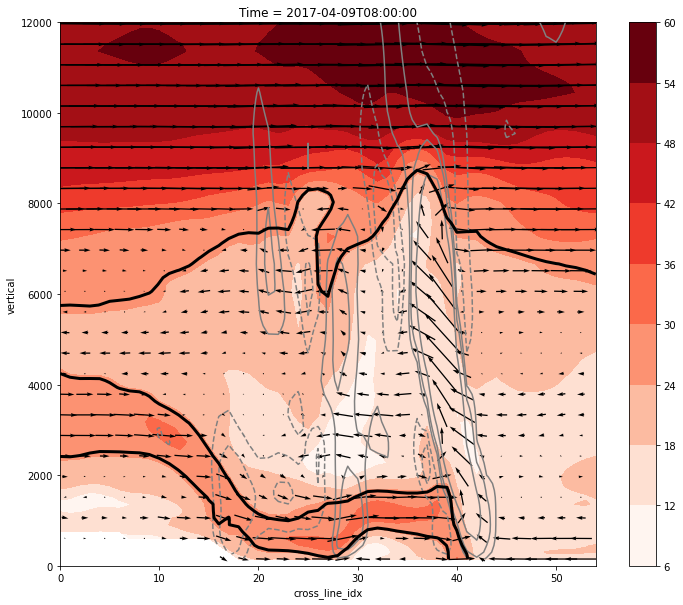

In [101]:
#Same plot but wind speed

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

#xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
xr.plot.contourf(np.sqrt(((u_cross**2) + (v_cross**2))),cmap=plt.get_cmap("Reds"),levels=10)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="gray")
xr.plot.contour(np.sqrt(((u_cross**2) + (v_cross**2))),levels=[25],colors="k",linewidths=3)
plt.ylim([0,12000])

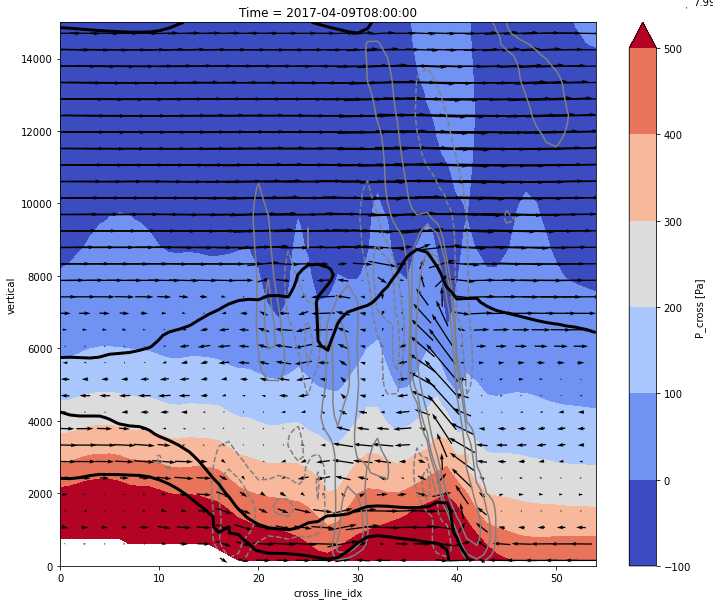

In [130]:
# #Same plot but perturbation pressure

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*1}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean06 = wind_transect.sel({"vertical":slice(0,6000)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean06

#xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
levs = [-100,0,100,200,300,400,500]
xr.plot.contourf(p_cross,levels=levs, cmap=plt.get_cmap("coolwarm"))
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="gray")
xr.plot.contour(np.sqrt(((u_cross**2) + (v_cross**2))),levels=[25],colors="k",linewidths=3)
#plt.ylim([0,8000])

In [122]:
len(list(plt.get_cmap("RdBu_r")(np.array(levs)/500.)))

7

Text(0.5, 1.0, 'Wind speed and direction at 1000 m ASL: 2017-04-09 08:00 UTC')

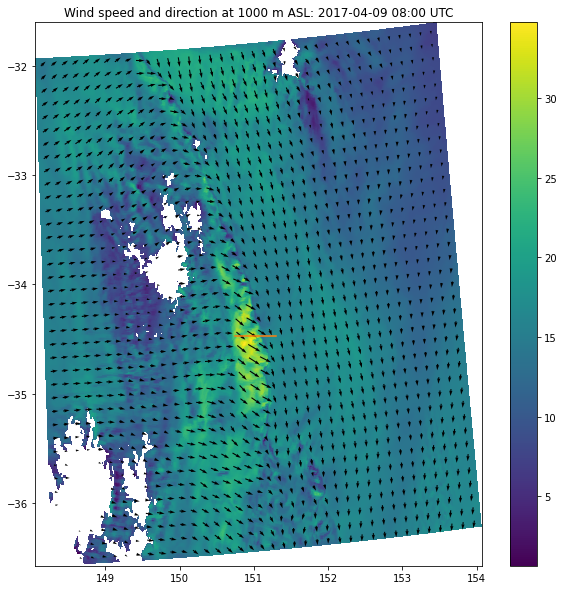

In [58]:
plt.figure(figsize=[10,10])
u=wrf.interpz3d(wrf.destagger(wrf.getvar(wrflist,"U",timeidx=t_ind),2,meta=True),heights,np.array([1000.0]),missing=np.nan,meta=True).squeeze()
v=wrf.interpz3d(wrf.destagger(wrf.getvar(wrflist,"V",timeidx=t_ind),1,meta=True),heights,np.array([1000.0]),missing=np.nan,meta=True).squeeze()

c=plt.pcolormesh(wrf.getvar(wrflist,"XLONG").values,
               wrf.getvar(wrflist,"XLAT").values,
               np.sqrt(u**2+v**2).values)
plt.colorbar(c)

plt.quiver(wrf.getvar(wrflist,"XLONG").coarsen(dim={"south_north":10,"west_east":10},boundary="trim").median().values,
           wrf.getvar(wrflist,"XLAT").coarsen(dim={"south_north":10,"west_east":10},boundary="trim").median().values,
           u.coarsen(dim={"south_north":10,"west_east":10},boundary="trim").mean().values,
           v.coarsen(dim={"south_north":10,"west_east":10},boundary="trim").mean().values)

plt.plot(lons, lats,color="tab:orange",ls="-")

plt.title("Wind speed and direction at 1000 m ASL: 2017-04-09 08:00 UTC")

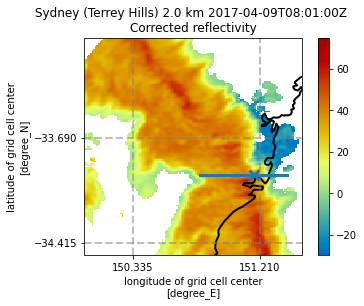

In [72]:
#Now, look at radar obs

radar=load_radar("71",dt.datetime(2017,4,9,8,2))

ax=plt.axes(projection=ccrs.PlateCarree())
disp=pyart.graph.GridMapDisplay(radar)
disp.plot_grid("corrected_reflectivity",level=4, ax=ax)
ax.set_xlim([150,151.5])
ax.set_ylim([-34.5,-33])

ax.plot(plon,plat,marker="x",ms=10,mew=3)

# ax.plot(143.644,-37.9931,marker="$c$",color="k",ms=10,mew=2)
# ax.plot(143.79,-38.23,marker="$AWS$",color="k",ms=30,mew=0.5)
# ax.plot(143.6,-37.92,marker="x",color="k",ms=10,mew=4)

ax.plot([150.8,151.4],[-33.9465,-33.9465],color="tab:blue",lw=3)

(1500.0, 11000.0)

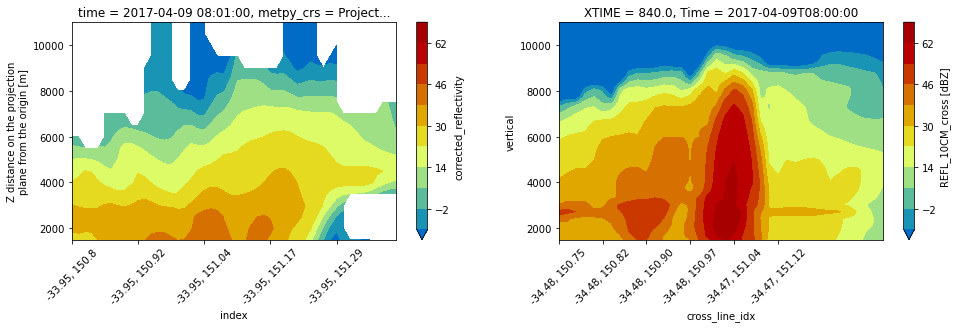

In [73]:
#Compare a cell transect from the observed radar reflectivity with the model reflectivity

def get_xlabs(cross):
    lon_str = cross.lon.values.round(2).astype(str)
    lat_str = cross.lat.values.round(2).astype(str)
    xlab = [i + ", " + j for i, j in zip(lat_str,lon_str)]
    return xlab

cross=cross_section(radar.to_xarray().isel({"time":0}).corrected_reflectivity.assign_coords(
    x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
    grid_mapping_name='latitude_longitude',
    earth_radius=6371229.0
),[-33.9465,150.8],[-33.9465,151.4],steps=50)

plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
xr.plot.contourf(cross,
    vmin=-10, 
    vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
plt.ylim([1500,11000])
plt.xticks(np.arange(0,50,10),get_xlabs(cross)[0::10])
plt.gca().tick_params(axis="x",rotation=45)

plt.subplot(1,2,2)
xr.plot.contourf(refl_cross.sel({"cross_line_idx":slice(0,40)}),
    vmin=-10, 
    vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
plt.xticks(np.arange(0,30,5),[refl_cross.sel({"cross_line_idx":slice(0,40)}).isel({"cross_line_idx":np.arange(0,30,5)}).xy_loc.values[i].latlon_str(fmt='{:.2f}, {:.2f}') for i in np.arange(len(np.arange(0,30,5)))])
plt.gca().tick_params(axis="x",rotation=45)
plt.ylim([1500,11000])